In [4]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\swhon\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [5]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\swhon\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import WOEEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sns.set_style('whitegrid') 
sns.set_palette('pastel')  

import warnings
warnings.simplefilter("ignore")

In [14]:
train_df = pd.read_csv('fraudTrain.csv', index_col='Unnamed: 0')

In [15]:
test_df = pd.read_csv('fraudTest.csv', index_col='Unnamed: 0')

# Step1. Exploratory Data Analysis 

In [16]:
train_df.head(3)
train_df.info()
train_df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

(1296675, 22)

In [17]:
is_fraud = train_df["is_fraud"].value_counts()
print("Yes: ",is_fraud[1])
print("No: ",is_fraud[0])

Yes:  7506
No:  1289169


In [18]:
print(train_df.isna().sum().sum())
print(train_df.duplicated().sum())

0
0


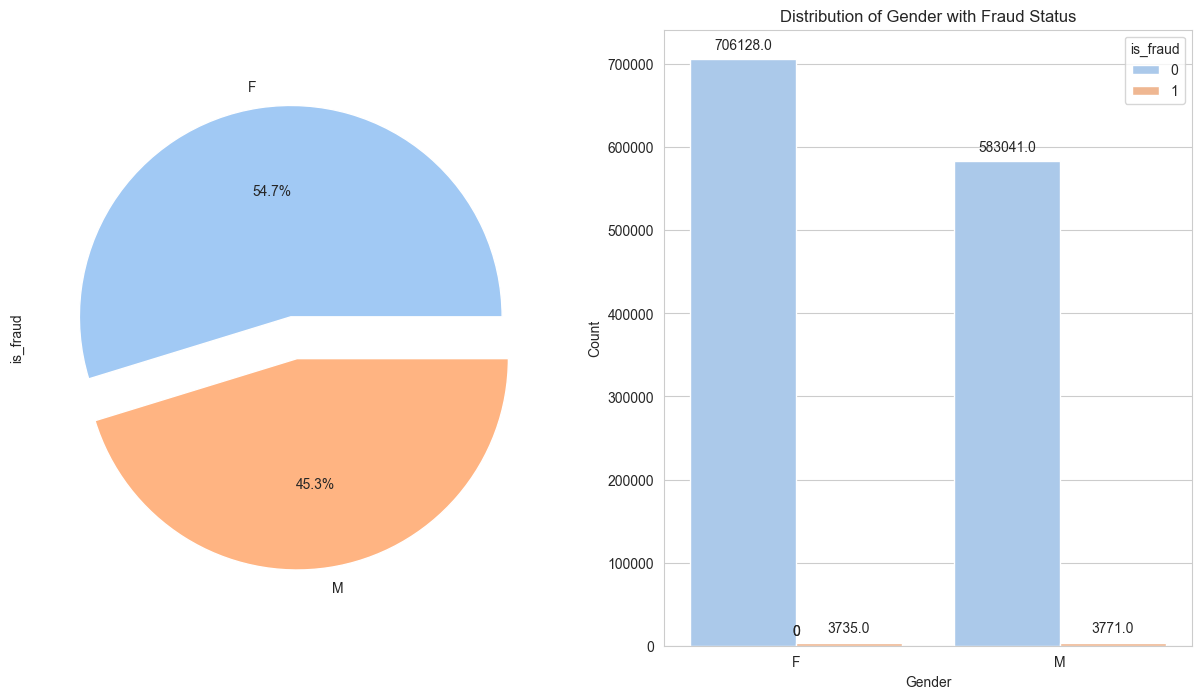

In [19]:
fig,axb = plt.subplots(ncols=2,nrows=1,figsize=(15, 8))

#Gender Distribution
explode = [0.1, 0.1]
train_df.groupby('gender')['is_fraud'].count().plot.pie(explode=explode, autopct="%1.1f%%",ax=axb[0]);

ax = sns.countplot(x="gender", hue="is_fraud", data=train_df,ax=axb[1])

# Add values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set labels and title
plt.title("Distribution of Gender with Fraud Status")
plt.xlabel("Gender")
plt.ylabel("Count")

# Show the plot
plt.show()

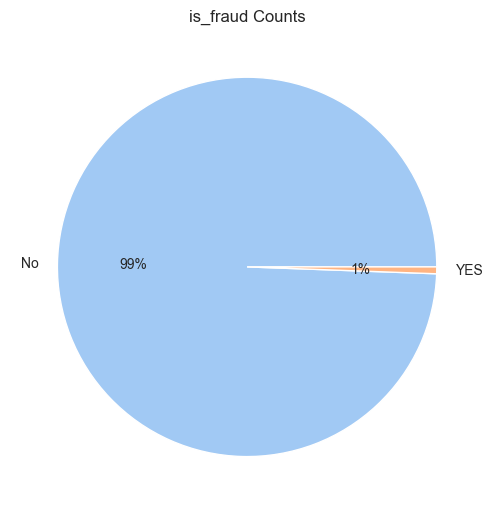

In [20]:
is_fraud = train_df["is_fraud"].value_counts()
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)  # Subplot for the pie chart
plt.pie(is_fraud, labels=["No", "YES"], autopct="%0.0f%%")
plt.title("is_fraud Counts")
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [21]:
train_df['trans_date_trans_time'] = pd.to_datetime(train_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')
test_df['trans_date_trans_time'] = pd.to_datetime(test_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')

In [22]:
train_df['hour'] = train_df['trans_date_trans_time'].dt.hour
test_df['hour'] = test_df['trans_date_trans_time'].dt.hour

train_df['month'] = train_df['trans_date_trans_time'].dt.month
test_df['month'] = test_df['trans_date_trans_time'].dt.month

train_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,month
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,1
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,1
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,1
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,1
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,1


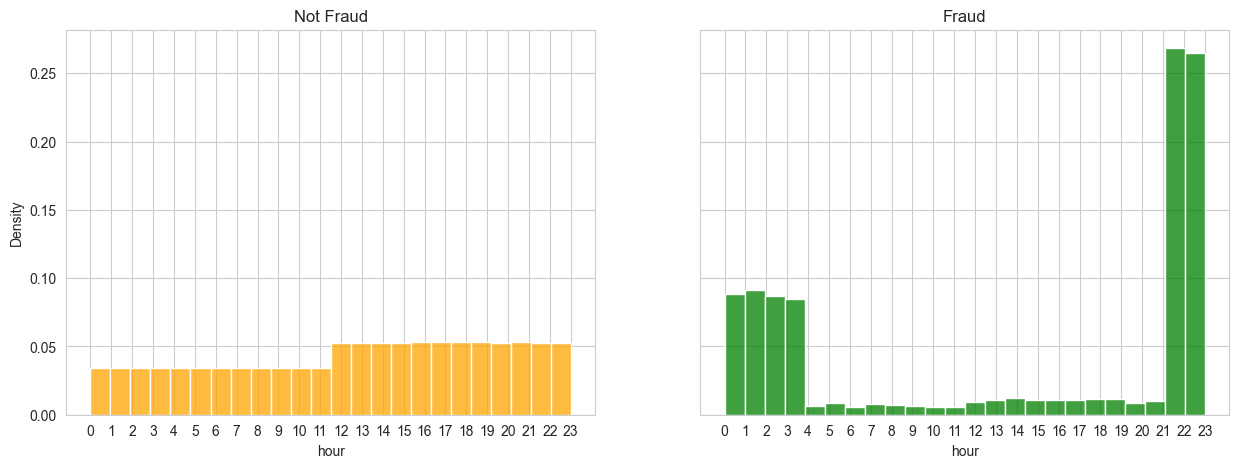

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True)

ax1 = sns.histplot(x='hour', data=train_df[train_df["is_fraud"] == 0],
                   stat="density", bins=24, ax=ax1, color="orange")

ax2 = sns.histplot(x='hour', data=train_df[train_df["is_fraud"] == 1],
                   stat="density", bins=24, ax=ax2, color="green")

ax1.set_title("Not Fraud")
ax2.set_title("Fraud")

ax1.set_xticks(np.arange(24)) # ticks of the day 0 -> 23
ax2.set_xticks(np.arange(24));

------

# Step2. Pre-Processing

In [24]:
unique_transaction_count = len(train_df['trans_num'].unique())
print("Total count of unique transaction numbers:", unique_transaction_count)

Total count of unique transaction numbers: 1296675


In [25]:
# remove non-useful columns
columns_to_drop = ['first', 'unix_time', 'dob', 'cc_num', 'zip', 'city','street', 'state', 'trans_num', 'trans_date_trans_time']
train_df = train_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)
train_df.head(2)

,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,Banks,F,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0,0,1
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Gill,F,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0,0,1


In [26]:
train_df['merchant'] = train_df['merchant'].apply(lambda x : x.replace('fraud_',''))

In [27]:
test_df['merchant'] = test_df['merchant'].apply(lambda x : x.replace('fraud_',''))

In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 14 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   merchant    1296675 non-null  object 
 1   category    1296675 non-null  object 
 2   amt         1296675 non-null  float64
 3   last        1296675 non-null  object 
 4   gender      1296675 non-null  object 
 5   lat         1296675 non-null  float64
 6   long        1296675 non-null  float64
 7   city_pop    1296675 non-null  int64  
 8   job         1296675 non-null  object 
 9   merch_lat   1296675 non-null  float64
 10  merch_long  1296675 non-null  float64
 11  is_fraud    1296675 non-null  int64  
 12  hour        1296675 non-null  int64  
 13  month       1296675 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 148.4+ MB


In [29]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 555719 entries, 0 to 555718
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   merchant    555719 non-null  object 
 1   category    555719 non-null  object 
 2   amt         555719 non-null  float64
 3   last        555719 non-null  object 
 4   gender      555719 non-null  object 
 5   lat         555719 non-null  float64
 6   long        555719 non-null  float64
 7   city_pop    555719 non-null  int64  
 8   job         555719 non-null  object 
 9   merch_lat   555719 non-null  float64
 10  merch_long  555719 non-null  float64
 11  is_fraud    555719 non-null  int64  
 12  hour        555719 non-null  int64  
 13  month       555719 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 63.6+ MB


------

# Step3. Encoding

In [30]:
# applying label encoding
train_df['gender'] = train_df['gender'].map({'F': 0, 'M': 1})

# applying WOE encoding
for col in ['job','merchant', 'category', 'lat', 'last']:
    train_df[col] = WOEEncoder().fit_transform(train_df[col],train_df['is_fraud'])

In [31]:
# applying label encoding
test_df['gender'] = test_df['gender'].map({'F': 0, 'M': 1})

# applying WOE encoding
for col in ['job','merchant', 'category', 'lat', 'last']:
    test_df[col] = WOEEncoder().fit_transform(test_df[col],test_df['is_fraud'])

------

# Step4. Over-Sampling and Scaling

In [32]:
X=train_df.drop("is_fraud",axis=1)
y=train_df['is_fraud']

# train and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=65)

X_test=test_df.drop("is_fraud",axis=1)
y_test=test_df['is_fraud']


In [33]:
No_class = y_train[y_train==0]
yes_class = y_train[y_train==1]

In [34]:
print(len(No_class))
print(len(yes_class))

1031335
6005


In [35]:
!pip install -U imbalanced-learn

You should consider upgrading via the 'C:\Users\swhon\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [36]:
from imblearn.over_sampling import SMOTE

In [37]:
smote = SMOTE(random_state=65)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [38]:
print(sum(y_train_smote== 0))
print(sum(y_train_smote== 1))

1031335
1031335


In [39]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_smote)

X_val = scaler.transform(X_val)
X_test=scaler.transform(X_test)

------

In [40]:
len(X_train)

2062670

# Step5. Machine Learning model training

## 1. Logistic Regression -> LR

In [33]:
LR_model = LogisticRegression()
LR_model.fit(X_train, y_train_smote)
predict_LR = LR_model.predict(X_test)

print(classification_report(y_test, predict_LR))
LR_accuracy = accuracy_score(predict_LR,y_test)
print('Logistic Regression accuracy is: {:.2f}%'.format(LR_accuracy*100))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93    553574
           1       0.03      0.92      0.05      2145

    accuracy                           0.86    555719
   macro avg       0.51      0.89      0.49    555719
weighted avg       1.00      0.86      0.92    555719

Logistic Regression accuracy is: 86.30%


## 2. Support Vector Machine Model (SVC)

In [34]:
svm_model = LinearSVC()
svm_model.fit(X_train, y_train_smote)
predict = svm_model.predict(X_test)

print(classification_report(y_test, predict))
svm_accuracy = accuracy_score(predict,y_test)
print('SVC model accuracy is: {:.2f}%'.format(svm_accuracy*100))


              precision    recall  f1-score   support

           0       1.00      0.87      0.93    553574
           1       0.03      0.91      0.05      2145

    accuracy                           0.87    555719
   macro avg       0.51      0.89      0.49    555719
weighted avg       1.00      0.87      0.93    555719

SVC model accuracy is: 87.07%


## 3. Gaussian Naive Bayes model

In [35]:
# Create and train the Gaussian Naive Bayes model
NB_model = GaussianNB()
NB_model.fit(X_train, y_train_smote)

# Make predictions on the test set
y_pred_naive = NB_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_naive))
GaussianNB_accuracy = accuracy_score(y_pred_naive, y_test)
print('Naive Bayes model accuracy is: {:.2f}%'.format(GaussianNB_accuracy * 100))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93    553574
           1       0.02      0.78      0.04      2145

    accuracy                           0.86    555719
   macro avg       0.51      0.82      0.48    555719
weighted avg       1.00      0.86      0.92    555719

Naive Bayes model accuracy is: 86.37%


## 4. Decision Tree Model (ID3)

In [50]:
DT = DecisionTreeClassifier(max_depth=5, random_state=42)
DT.fit(X_train, y_train_smote)
predict_ID3 = DT.predict(X_test)
print(classification_report(y_test, predict_ID3))
ID3_accuracy = accuracy_score(predict_ID3,y_test)
print('ID3 model accuracy is: {:.2f}%'.format(ID3_accuracy*100))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97    553574
           1       0.05      0.91      0.10      2145

    accuracy                           0.93    555719
   macro avg       0.52      0.92      0.53    555719
weighted avg       1.00      0.93      0.96    555719

ID3 model accuracy is: 93.34%


## 5. RandomForestClassifier

In [51]:
# Initialize and train the Random Forest classifier
RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train, y_train_smote)

predict_RF = RF.predict(X_test)

# Evaluate the model
print(classification_report(y_test, predict_RF))
RF_accuracy = accuracy_score(predict_RF, y_test)
print('Random Forest model accuracy is: {:.2f}%'.format(RF_accuracy * 100))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95    553574
           1       0.03      0.87      0.06      2145

    accuracy                           0.90    555719
   macro avg       0.52      0.89      0.50    555719
weighted avg       1.00      0.90      0.94    555719

Random Forest model accuracy is: 89.86%


In [52]:
Algorithms = ['RandomForest', 'Decision Tree', 'Logistic Regression', 'Support Vector Machine', 'Gaussian Naive Bayes']
accuracy = [RF_accuracy, ID3_accuracy, LR_accuracy, svm_accuracy, GaussianNB_accuracy]

FinalResult=pd.DataFrame({'Algorithm':Algorithms, 'Accuracy':accuracy})
FinalResult

,Algorithm,Accuracy
0,RandomForest,0.898602
1,Decision Tree,0.933445
2,Logistic Regression,0.863048
3,Support Vector Machine,0.870668
4,Gaussian Naive Bayes,0.863719


In [53]:
import joblib

In [54]:
joblib.dump(DT, 'decision_tree_model.joblib')

['decision_tree_model.joblib']

# FastAPI

In [41]:
!pip install fastapi
!pip install uvicorn
!pip install pydantic

You should consider upgrading via the 'C:\Users\swhon\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\swhon\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\swhon\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [42]:
from fastapi import FastAPI
from pydantic import BaseModel
import uvicorn
import nest_asyncio

from typing import Union

In [43]:
model=joblib.load("decision_tree_model.joblib")

In [44]:
nest_asyncio.apply()

In [45]:
train_df

,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
0,0.959326,0.924914,4.97,-2.469513,0,36.0788,-81.1781,3495,-1.080186,36.011293,-82.048315,0,0,1
1,0.663187,0.898799,107.23,-0.673638,0,48.8878,-118.2105,149,-0.904144,49.159047,-118.186462,0,0,1
2,-0.790166,-0.847622,220.11,0.433257,1,42.1808,-112.2620,4154,1.120434,43.150704,-112.154481,0,0,1
3,-0.416817,-0.209382,45.00,0.148996,1,46.2306,-112.1138,1939,0.361872,47.034331,-112.561071,0,0,1
4,-0.277905,-0.611091,41.96,0.423436,1,38.4207,-79.4629,99,-2.464077,38.674999,-78.632459,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,-0.613642,-0.847622,15.56,-0.195618,1,37.7175,-112.4777,258,-0.049141,36.841266,-111.690765,0,12,6
1296671,-0.711004,-1.252360,51.70,0.148996,1,39.2667,-77.5101,100,1.081518,38.906881,-78.246528,0,12,6
1296672,-1.279624,-1.252360,105.93,0.132409,1,32.9396,-105.8189,899,0.071538,33.619513,-105.130529,0,12,6
1296673,-0.798063,-1.252360,74.90,-0.646510,1,43.3526,-102.5411,1126,-0.266356,42.788940,-103.241160,0,12,6


In [46]:
for column_name, dtype in zip(train_df.columns, train_df.dtypes):
    print(f"Column: {column_name}, DataType: {dtype}")

Column: merchant, DataType: float64
Column: category, DataType: float64
Column: amt, DataType: float64
Column: last, DataType: float64
Column: gender, DataType: int64
Column: lat, DataType: float64
Column: long, DataType: float64
Column: city_pop, DataType: int64
Column: job, DataType: float64
Column: merch_lat, DataType: float64
Column: merch_long, DataType: float64
Column: is_fraud, DataType: int64
Column: hour, DataType: int64
Column: month, DataType: int64


Version 1

In [47]:
for column_name, dtype in zip(test_df.columns, test_df.dtypes):
    print(f"Column: {column_name}, DataType: {dtype}")

Column: merchant, DataType: float64
Column: category, DataType: float64
Column: amt, DataType: float64
Column: last, DataType: float64
Column: gender, DataType: int64
Column: lat, DataType: float64
Column: long, DataType: float64
Column: city_pop, DataType: int64
Column: job, DataType: float64
Column: merch_lat, DataType: float64
Column: merch_long, DataType: float64
Column: is_fraud, DataType: int64
Column: hour, DataType: int64
Column: month, DataType: int64


In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
from typing import Union
import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from category_encoders import WOEEncoder
from datetime import datetime


# loading the model 
model = joblib.load("random_forest_model.joblib")

api_title = "CreditCardFraudDetectionApp"
api_description = """
CreditCardFraudDetectionApp allows you to predict if a transaction is fraudulent or not.
"""

app = FastAPI(title=api_title, description=api_description)

class TransactionInput(BaseModel):
    merchant: str
    category: str
    amt: float
    last: str
    gender: str  
    lat: float
    long: float
    city_pop: int
    job: str
    merch_lat: float
    merch_long: float 
    trans_date_trans_time:str

class PredictOutput(BaseModel):
    is_fraud: bool
    probability: float

def data_preprocessing(transaction:TransactionInput):
    # Convert trans_date_trans_time to datetime object
    transaction.trans_date_trans_time = datetime.strptime(transaction.trans_date_trans_time, "%Y-%m-%d %H:%M:%S")

    # Create hour and month columns
    transaction.hour = transaction.trans_date_trans_time.hour
    transaction.month = transaction.trans_date_trans_time.month

    # Rename 'merchant' 
    transaction.merchant = transaction.merchant.replace('fraud_', '')

    # Encode 'gender'
    transaction.gender = 0 if transaction.gender == 'F' else 1

    # Applying WOE encoding
    encoder = WOEEncoder()
    transaction_dict = transaction.dict()
    for col in ['job', 'merchant', 'category', 'lat', 'last']:
        transaction_dict[col] = encoder.fit_transform(transaction_dict[col], transaction_dict['is_fraud'])

    # Convert dictionary back to TransactionInput object
    processed_transaction = TransactionInput(**transaction_dict)

    return processed_transaction

@app.get("/")
def root():
    return "Hello! This is the credit card fraud prediction ML service!"

@app.post("/predict", response_model=PredictOutput)
def predict_fraud(transaction: TransactionInput):
    processed_data = data_preprocessing(transaction)
    features = np.array([processed_data])
    prediction = model.predict(features)
    probability = model.predict_proba(features)[:, 1][0]

    return PredictOutput(is_fraud=bool(prediction[0]), probability=float(probability))

@app.get("/transactions/{transaction_id}")
def read_transaction(transaction_id: int, q: Union[str, None] = None):
    return {"transaction_id": transaction_id, "q": q}

@app.put("/transactions/{transaction_id}")
def update_transaction(transaction_id: int, transaction: TransactionInput):
    return {"transaction_amt": transaction.amt, "transaction_id": transaction_id}


Version 2

In [49]:
# api_title="CreditCardFraudDetectionApp"
# api_description="""
# CreditCardFraudDetectionApp allows you to predict if a transaction is fraudulent or not.
# """

# app=FastAPI(title=api_title,description=api_description)

# class TransactionInput(BaseModel):
#     amt: float
#     category: str
#     merch_lat: float
#     merch_long: float

# class PredictOutput(BaseModel):
#     is_fraud: Union[bool, None] = None
#     probability: Union[float, None] = None

# @app.get("/") # sending the data 
# def root():
#     return "Hello! This is the credit card fraud prediction ML service!"

# @app.post("/predict/",response_model=PredictOutput)
# def predict_fraud(transaction:TransactionInput)->bool:
#     features=np.array([[transaction.amt, transaction.category,transaction.merch_lat,transaction.merch_long]])
#     prediction=model.predict(features)
#     is_fraud=bool(prediction[0])
#     response_data={
#         "is_fraud": is_fraud,
#         "message": "This transaction is likely to be fraudulent" if is_fraud else "This transaction is not likely to be fraudulent"
#     }
#     return response_data

jinny's

In [65]:
app = FastAPI(title="CreditCardFraudDetectionApp", description="Predicts credit card fraud.")

class TransactionInput(BaseModel):
    merchant: str
    category: str
    amt: float
    last: str
    gender: str
    lat: float
    long: float
    city_pop: int
    job: str
    merch_lat: float
    merch_long: float
    hour: int
    month: int

class PredictOutput(BaseModel):
    is_fraud: bool
    probability: float

@app.get("/")
def root():
    return {"message": "Welcome to the Credit Card Fraud Detection API."}

@app.post("/predict", response_model=PredictOutput)
def predict_fraud(transaction: TransactionInput):
    try:
        features = prepare_features(transaction)
        prediction = model.predict(features)
        probability = model.predict_proba(features)[:, 1][0]
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))
    
    return PredictOutput(is_fraud=bool(prediction[0]), probability=float(probability))

@app.put("/transactions/{transaction_id}")
def prepare_features(transaction: TransactionInput):
    processed_features = np.array([[transaction.amt, transaction.lat, transaction.long, transaction.city_pop, transaction.merch_lat, transaction.merch_long, transaction.hour, transaction.month]])
    return processed_features

#@app.put("/transactions/{transaction_hyojinkim220}")
#def update_transaction(transaction_hyojinkim220: int, transaction: TransactionInput):
 #   return {"transaction_amt": transaction.amt, "transaction_id": transaction_hyojinkim220}

In [50]:
!pip install nest_asyncio

You should consider upgrading via the 'C:\Users\swhon\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [76]:
import asyncio

async def run_server():
    await uvicorn.run(app, host="127.0.0.1", port=8000)

await run_server()

INFO:     Started server process [5096]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:63947 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:63948 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:63948 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:63949 - "POST /predict HTTP/1.1" 422 Unprocessable Entity
INFO:     127.0.0.1:63974 - "POST /predict HTTP/1.1" 500 Internal Server Error


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "c:\Users\swhon\AppData\Local\Programs\Python\Python39\lib\site-packages\uvicorn\protocols\http\httptools_impl.py", line 411, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
  File "c:\Users\swhon\AppData\Local\Programs\Python\Python39\lib\site-packages\uvicorn\middleware\proxy_headers.py", line 69, in __call__
    return await self.app(scope, receive, send)
  File "c:\Users\swhon\AppData\Local\Programs\Python\Python39\lib\site-packages\fastapi\applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "c:\Users\swhon\AppData\Local\Programs\Python\Python39\lib\site-packages\starlette\applications.py", line 123, in __call__
    await self.middleware_stack(scope, receive, send)
  File "c:\Users\swhon\AppData\Local\Programs\Python\Python39\lib\site-packages\starlette\middleware\errors.py", line 186, in __call__
    raise exc
  File "c:\Users\swhon

TypeError: object NoneType can't be used in 'await' expression

In [77]:
# import requests

# # API endpoint URL
# url = 'http://127.0.0.1:8000/predict'

# # data to request
# transaction_data = {
#     "amt": 2.86,
#     "category": 'personal_care',
#     "merch_lat": 33.986391,
#     "merch_long": -81.200714
# }

# # POST
# response = requests.post(url, json=transaction_data)

# # response
# if response.status_code == 200:
#     prediction_result = response.json()
#     print("API response:", prediction_result)
# else:
#     print("API request failed:", response.status_code, response.text)
